# TripAdvisor Web Scraping

In [154]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.webdriver.support.wait import WebDriverWait

from datetime import datetime
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [128]:
#get browser, maximise window, open web page

browser = webdriver.Edge(service=Service(EdgeChromiumDriverManager().install()))
browser.maximize_window()

browser.get('https://www.tripadvisor.com/Hotel_Review-g187849-d2340336-Reviews-Armani_Hotel-Milan_Lombardy.html')

In [129]:
#waiting timeout 3 seconds for cookies button,find lambda expression equal to id inside HTML code, then click

cookies_wait = WebDriverWait(browser,timeout= 3)
#browser.find_element()
cookies_accept = cookies_wait.until(lambda b: b.find_element('xpath', '//*[@id="onetrust-accept-btn-handler"]'))

cookies_accept.click()

In [130]:
#Select all the elements that have the expand-review
def expand_reviews(browser):
    expand = browser.find_element('xpath',".//div[contains(@data-test-target,'expand-review')]")
    if expand:
        expand.click()

In [131]:
#expand all the page's reviews 

reviews = browser.find_elements('xpath',".//div[@data-reviewid]")
reviews

[<selenium.webdriver.remote.webelement.WebElement (session="707c66388d0ceca18eb14b0703e37684", element="BBD0282C7C521FF4695FC7AEBB1865EE_element_50")>,
 <selenium.webdriver.remote.webelement.WebElement (session="707c66388d0ceca18eb14b0703e37684", element="BBD0282C7C521FF4695FC7AEBB1865EE_element_51")>,
 <selenium.webdriver.remote.webelement.WebElement (session="707c66388d0ceca18eb14b0703e37684", element="BBD0282C7C521FF4695FC7AEBB1865EE_element_52")>,
 <selenium.webdriver.remote.webelement.WebElement (session="707c66388d0ceca18eb14b0703e37684", element="BBD0282C7C521FF4695FC7AEBB1865EE_element_53")>,
 <selenium.webdriver.remote.webelement.WebElement (session="707c66388d0ceca18eb14b0703e37684", element="BBD0282C7C521FF4695FC7AEBB1865EE_element_54")>,
 <selenium.webdriver.remote.webelement.WebElement (session="707c66388d0ceca18eb14b0703e37684", element="BBD0282C7C521FF4695FC7AEBB1865EE_element_55")>,
 <selenium.webdriver.remote.webelement.WebElement (session="707c66388d0ceca18eb14b0703e3

In [132]:
# Define the headers
headers = ['score', 'year', 'month', 'title', 'comment']

try:
    with open('ArmaniHotelReviews.csv', 'w', encoding="utf-8", newline='') as csvFile:
        csvWriter = csv.writer(csvFile)
        
        # Write the headers to the CSV file
        csvWriter.writerow(headers)

        for i in range(10):  # loop 10 pages
            time.sleep(3)

            expand_reviews(browser)
            reviews = browser.find_elements('xpath', ".//div[@data-reviewid]")
            for review in reviews:
                bubble_rating = review.find_element('xpath', ".//span[contains(@class,'ui_bubble_rating bubble_')]")
                score = bubble_rating.get_attribute("class").split("_")[3]

                date_obj = review.find_element('xpath', ".//span[@class='teHYY _R Me S4 H3']")
                date_rec = date_obj.text.replace("Date of stay:", '').strip()    # Remove leading/trailing spaces from the begining to the end sentence
                # Remove extra space before the month name
                date_rec = ' '.join(date_rec.split()) 
                
                date = datetime.strptime(date_rec, "%B %Y")

                title = review.find_element('xpath', ".//div[contains(@data-test-target, 'review-title')]").text

                comment = review.find_element('xpath', ".//span[@class='QewHA H4 _a']").text.replace("\n", " ")

                # Write the data to the CSV file
                csvWriter.writerow([score, date.year, date.month, title, comment])

            browser.find_element('xpath', './/a[@class="ui_button nav next primary "]').click()
finally:
    browser.quit()

# Analysis with Pandas

In [160]:
read_csv = pd.read_csv("ArmaniHotelReviews.csv",iterator=True)

In [134]:
dfs = []
for element in read_csv:
    df = pd.DataFrame(element)
    df1 = df.describe()
    dfs.append(df1.T)

df2 = pd.concat(dfs)
print(df2)

       count     mean       std     min     25%     50%     75%     max
score  100.0    46.40  8.935233    10.0    50.0    50.0    50.0    50.0
year   100.0  2020.46  1.585413  2018.0  2019.0  2021.0  2022.0  2023.0
month  100.0     7.36  3.227157     1.0     5.0     8.0    10.0    12.0


In [176]:
describe_num_df = df.describe(include=['int64','float64'])
describe_num_df.reset_index(inplace=True)
# To remove any variable from plot
describe_num_df = describe_num_df[describe_num_df['index'] != 'count']

num_col = df._get_numeric_data().columns
for i in num_col:
    if i == 'index':
        continue
    
    sns.catplot(x='index', y=i, data=df)
    plt.show()

ValueError: Could not interpret value `index` for parameter `x`

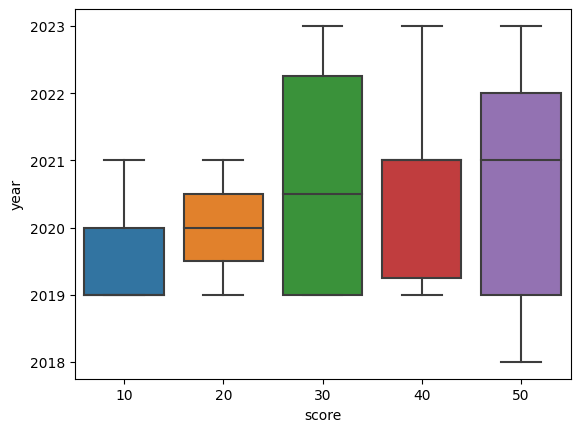

In [142]:
sns.boxplot(x = 'score',
            y = 'year',
            data = df)
 
# Show the plot
plt.show()

<AxesSubplot: xlabel='Count', ylabel='score'>

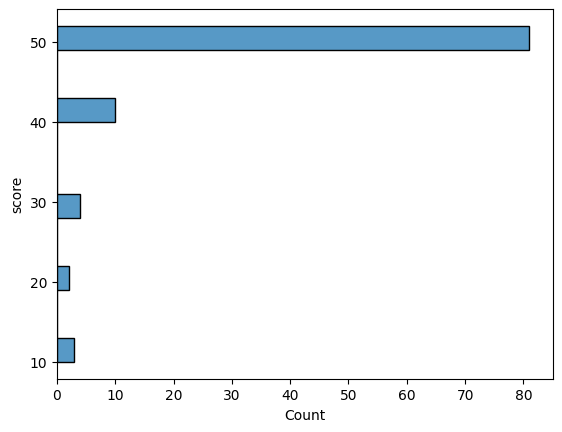

In [150]:
sns.histplot(data=df, y="score", binwidth=3)

# Sentimental Analysis

Identifies the key words


In [157]:
from wordcloud import WordCloud, STOPWORDS

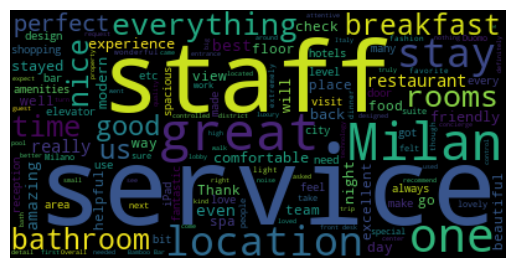

In [179]:
stopwords = set(STOPWORDS)
stopwords.update(['armani','room','hotel','star']) #undesired words
reviews = " ".join(review for review in df.comment)
wordcloud = WordCloud(stopwords=stopwords).generate(reviews) #generate the wordcloud without the undesired words
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\IreneDeNevi\AppData\Local\Temp\ipykernel_12756\3020690569.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


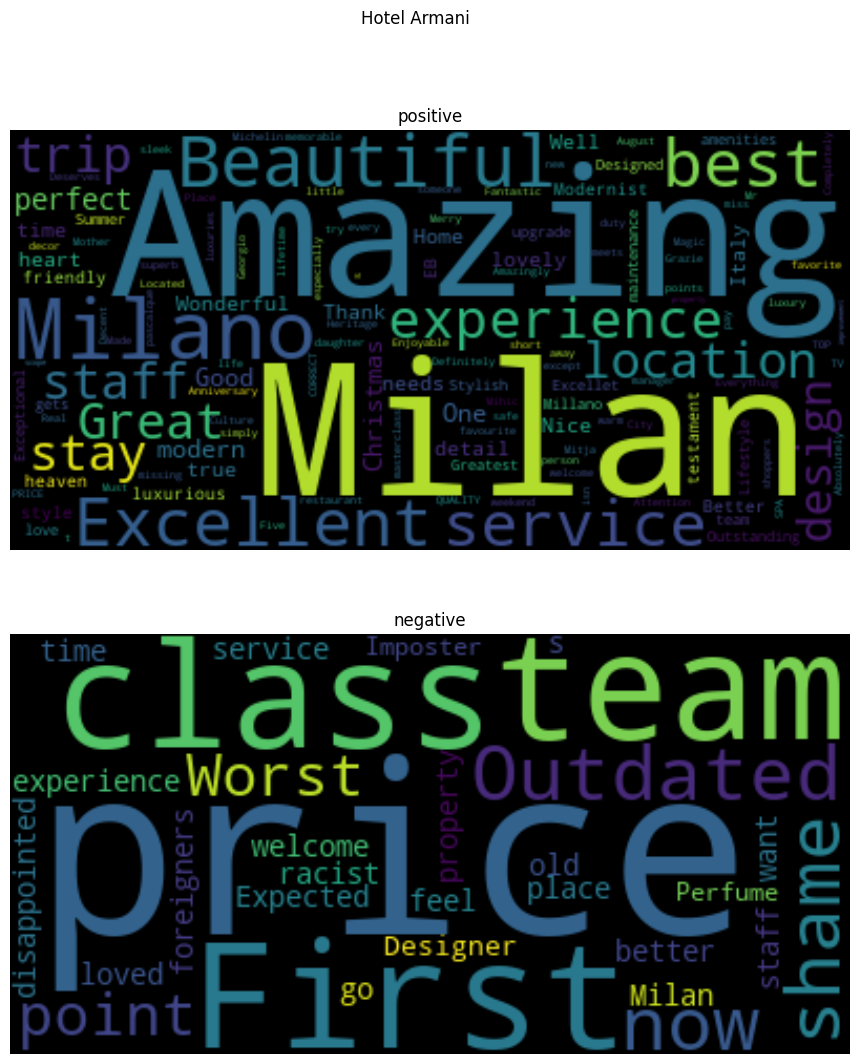

In [180]:
# assign reviews with Rating > 30 as positive sentiment
# rating < 30 negative sentiment
# remove rating = 30

df['sentiment'] = df['score'].apply(lambda score : +1 if score > 30 else -1)

#split df - positive and negative sentiment
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

pos = " ".join(review for review in positive.title)
wordcloud_pos = WordCloud(stopwords=stopwords).generate(pos)
neg = " ".join(review for review in negative.title)
wordcloud_neg = WordCloud(stopwords=stopwords).generate(neg)

fig,axes = plt.subplots(2,1, figsize = (12,12))
axes[0].imshow(wordcloud_pos,interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('positive')
axes[1].imshow(wordcloud_neg,interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('negative')
fig.suptitle('Hotel Armani')
fig.show()